In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pycolmap
import matplotlib.pyplot as plt

from hloc.visualization import plot_images
from megadepth.utils.io import load_depth_map, load_image
from megadepth.postprocessing.image_processing import filter_unstable_depths, erode_and_remove

In [3]:
data = Path("/Volumes/Extreme_SSD/MegaDepth/scenes/")
# data = Path("../../data/scenes/")

scene = "5018"

model_name = "disk_lg+sift+splg"
# model_name = "superpoint_max-superglue-netvlad-50-KA+BA"
# model_name = "baseline"


img_dir = data / scene / "images"
undistorted_img_dir = data / scene / "dense" / model_name / "images"

depth_dir = data / scene / "dense" / model_name / "stereo" / "depth_maps"

model_path = data / scene / "dense" / model_name / "sparse"

model = pycolmap.Reconstruction(model_path)
print(model.summary())

Reconstruction:
	num_reg_images = 79
	num_cameras = 2
	num_points3D = 85066
	num_observations = 519844
	mean_track_length = 6.11107
	mean_observations_per_image = 6580.3
	mean_reprojection_error = 0.966188


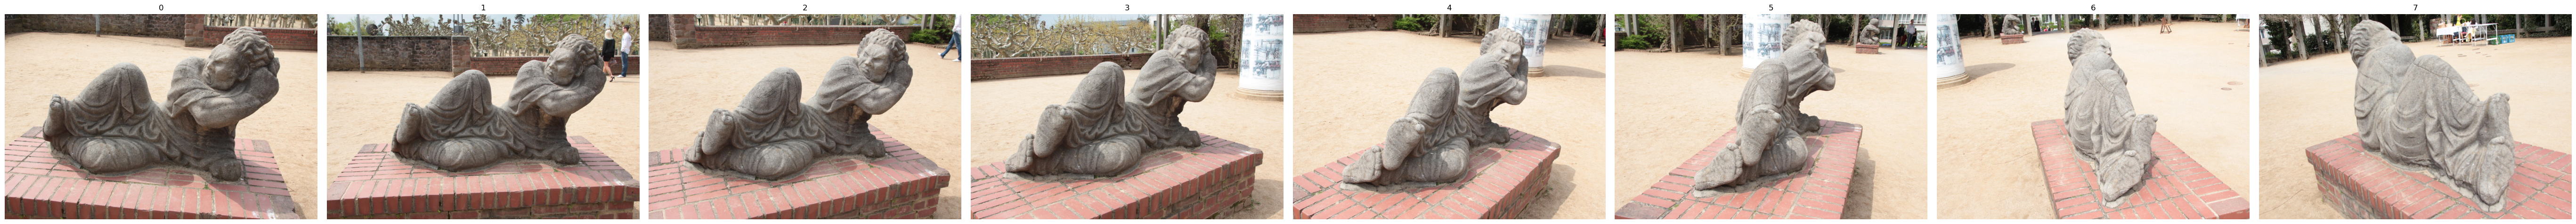

In [4]:
image_names = [im.name for im in model.images.values()]

N = 8

plot_images([load_image(undistorted_img_dir / im) for im in image_names[:N]], titles=range(N))

In [5]:
id_1 = 0
id_2 = 3

img1_name = image_names[id_1]
img2_name = image_names[id_2]

In [6]:
img1_name, img2_name

('IMG_0213.JPG', 'IMG_0210.JPG')

77 74


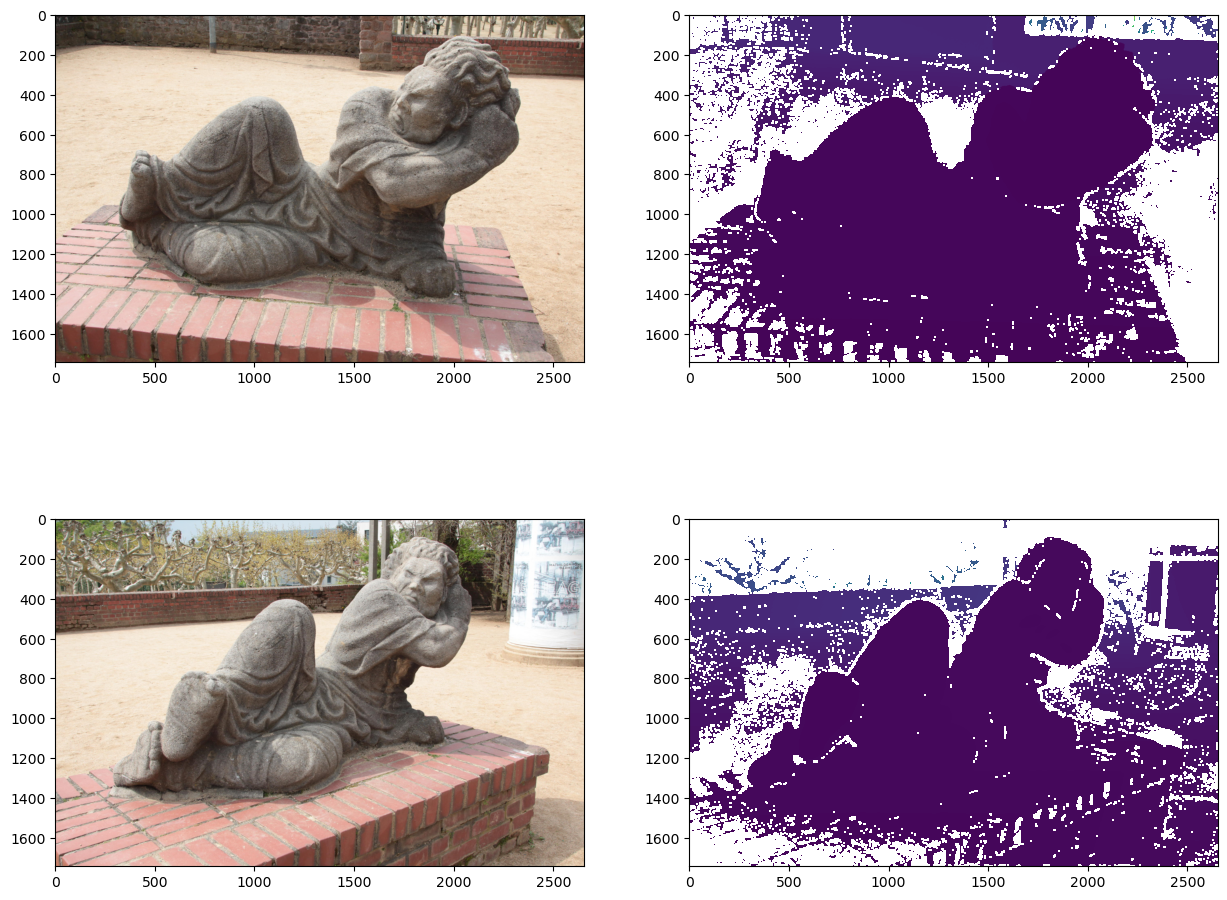

In [7]:
img1 = model.find_image_with_name(img1_name)
img2 = model.find_image_with_name(img2_name)

print(img1.image_id, img2.image_id)

cam1 = model.cameras[img1.camera_id]
cam2 = model.cameras[img2.camera_id]

depth1 = load_depth_map(depth_dir / f"{img1_name}.geometric.bin")
depth2 = load_depth_map(depth_dir / f"{img2_name}.geometric.bin")

depth1[depth1 <= 0] = np.nan
depth2[depth2 <= 0] = np.nan

fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax[0, 0].imshow(load_image(undistorted_img_dir / img1_name))
ax[1, 0].imshow(load_image(undistorted_img_dir / img2_name))

ax[0, 1].imshow(erode_and_remove(filter_unstable_depths(depth1)))
ax[1, 1].imshow(erode_and_remove(filter_unstable_depths(depth2)))

plt.show()

# Project one image into another image

In [8]:
def get_grid_points(depth):
    return np.column_stack(np.where(~np.isnan(depth)))

In [9]:
def img2world(img, cam, depth, colors):
    p2d = get_grid_points(depth)
    colors = colors[p2d[:, 0], p2d[:, 1]]
    depth = depth[p2d[:, 0], p2d[:, 1]]

    p3d = np.array(cam.image_to_world(p2d[:, ::-1]))
    p3d = np.stack([p3d[:, 0], p3d[:, 1], np.ones_like(p3d[:, 0])]) * depth
    p3d = np.array(img.transform_to_world(p3d.T))

    return p3d, colors

In [10]:
def world2img(p3d, img, cam):

    p2d = np.array(np.round(cam.world_to_image(img.project(p3d))), dtype=int)
    depth = np.array(img.transform_to_image(p3d))[:, 2]

    xmin, xmax = 0, cam.width
    ymin, ymax = 0, cam.height
    mask = (
        (p2d[:, 0] >= xmin)
        & (p2d[:, 0] < xmax)
        & (p2d[:, 1] >= ymin)
        & (p2d[:, 1] < ymax)
    )

    return p2d, mask, depth

In [11]:
def img2world2img(img1, img2, cam1, cam2, depth1, colors1):
    """Projects image 1 to world space, then projects world space to image 2."""    
    p3d, colors = img2world(img1, cam1, depth1, colors1)
    p2d, mask, depth = world2img(p3d, img2, cam2)

    p2d = p2d[mask]
    colors = colors[mask]
    depth = depth[mask]

    return p2d, depth, colors

In [12]:
def overlay(img1, img2, alpha=0.25):
    """Overlay two images."""
    return ((1 - alpha) * img1 + alpha * img2).astype(np.uint8)

def projection_img(proj, depth, colors, shape, filter=False):
    img = np.zeros(shape)
    d = np.zeros(shape)[:, :, 0]
    #argsort depth
    idx = np.argsort(depth)[::-1]

    for i in idx:
        img[proj[i, 1], proj[i, 0], :] = colors[i]
        d[proj[i, 1], proj[i, 0]] = depth[i]

    if filter:
        clean_depth = filter_unstable_depths(d.astype(np.uint8), 9)

        img[clean_depth == 0] = [0, 0, 0]

    return img.astype(np.uint8)

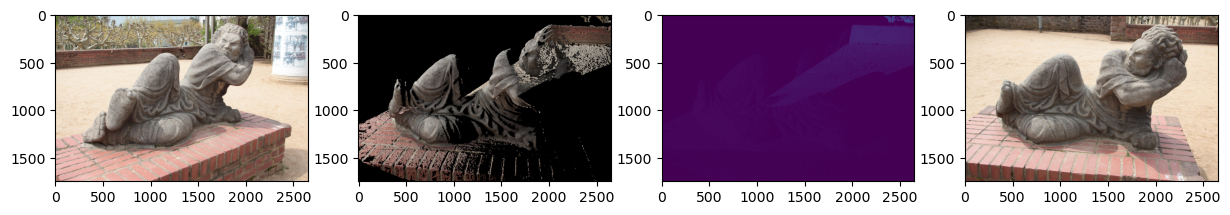

In [13]:
colors1 = load_image(undistorted_img_dir / img1.name)
colors2 = load_image(undistorted_img_dir / img2.name)

proj, depth, col = img2world2img(
    img1=img2,
    img2=img1,
    cam1=cam2,
    cam2=cam1,
    depth1=depth2,
    colors1=colors2,
)

img_proj = projection_img(proj, depth, col, colors1.shape, filter=True)

depth_proj = np.zeros_like(colors1)[:, :, 0]
depth_proj[proj[:, 1], proj[:, 0]] = depth

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(colors2)
ax[1].imshow(img_proj)
ax[2].imshow(depth_proj / depth_proj.max())
ax[3].imshow(colors1)

plt.show()

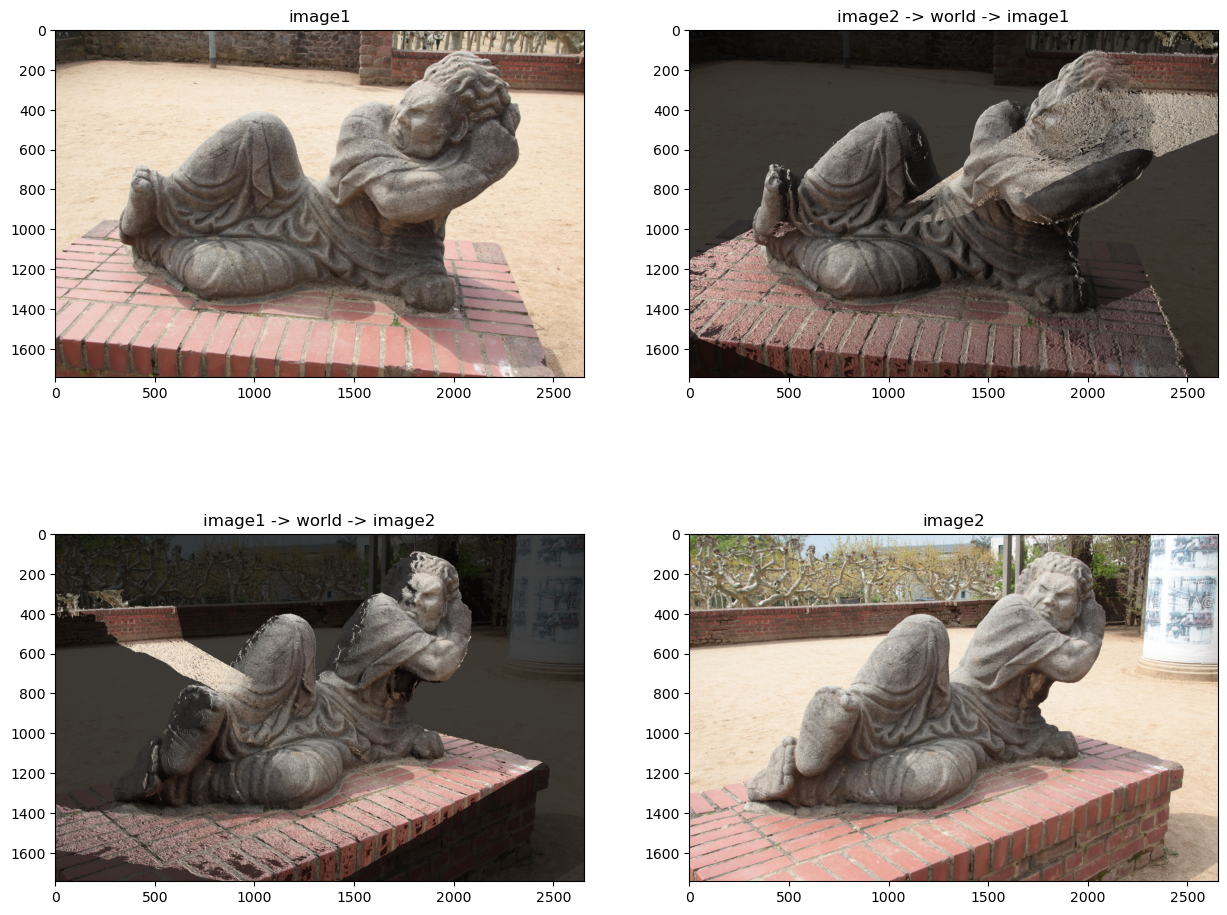

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
colors1 = load_image(undistorted_img_dir / img1.name)
colors2 = load_image(undistorted_img_dir / img2.name)

proj1to2, depth1to2, col1to2 = img2world2img(
    img1=img1,
    img2=img2,
    cam1=cam1,
    cam2=cam2,
    depth1=depth1,
    colors1=colors1,
)

img_proj1 = projection_img(proj1to2, depth1to2, col1to2, colors2.shape)

ax[0, 0].imshow(colors1)
ax[0, 0].set_title("image1")

ax[1, 0].imshow(overlay(img_proj1, colors2))
ax[1, 0].set_title("image1 -> world -> image2")


proj2to1, depth2to1, col2to1 = img2world2img(
    img1=img2,
    img2=img1,
    cam1=cam2,
    cam2=cam1,
    depth1=depth2,
    colors1=colors2,
)

img_proj2 = projection_img(proj2to1, depth2to1, col2to1, colors1.shape)

ax[1, 1].imshow(colors2)
ax[1, 1].set_title("image2")
ax[0, 1].imshow(overlay(img_proj2, colors1))
ax[0, 1].set_title("image2 -> world -> image1")

plt.show()

# Calc proj depth error

In [16]:
depth_proj = np.zeros_like(depth1)

for (x, y), d in zip(proj2to1, depth2to1):
    depth_proj[y, x] = d

mask = depth_proj * depth1 > 0

In [ ]:
def points_to_image(p2d, colors, shape):
    img = np.zeros(shape)

    for i in range(len(p2d)):
        x, y = p2d[i]
        img[y, x] = colors[i]

    return img

def calc_depth_error(depth, proj_depth):
    mask = depth * proj_depth > 0
    return np.abs((depth - proj_depth) * mask)

In [ ]:
dp = points_to_image(proj2to1, depth2to1, depth1.shape)
err = calc_depth_error(np.nan_to_num(depth1), dp)

# dp[dp <= 0] = np.nan
# err[err <= 0] = np.nan

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(depth1)
ax[1].imshow(dp)
ae = ax[2].imshow(err)

plt.colorbar(ae)

plt.show()


In [ ]:
dp = points_to_image(proj1to2, depth1to2, depth2.shape)
err = calc_depth_error(np.nan_to_num(depth2), dp)

# dp[dp <= 0] = np.nan
# err[err <= 0] = np.nan

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(depth2)
ax[1].imshow(dp)
ae = ax[2].imshow(err)

plt.colorbar(ae)

plt.show()